## Гибридные рекомендательные системы с Surprise: взвешенный подход
### Мы используем Suprise (пакет sci-kit для рекомендательных систем), чтобы гарантировать, что рекомендательные системы, которые мы используем, оптимизированы, чтобы когда мы объединили их - не беспокоились о недостатках, возникающих в отдельной реализации. 

In [1]:
import surprise
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader
from surprise import model_selection
from surprise import accuracy
from surprise import prediction_algorithms
import pickle


import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import os
path = "/"

Во-первых, давайте прочитаем и очистим набор данных, чтобы мы знали, с чем работаем.
1. Считайте pandas датафрейм ratings.csv
2. Удалите дублированные строки
3. Сколько уникальных книг и пользователей в датасете?
4. В каком интервале рейтинг?

### 1. Считайте pandas датафрейм ratings.csv

In [2]:
ratings = pd.read_csv('./ratings.csv')
ratings

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
...,...,...,...
981751,10000,48386,5
981752,10000,49007,4
981753,10000,49383,5
981754,10000,50124,5


### 2. Удалите дублированные строки

In [3]:
ratings.drop_duplicates()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
...,...,...,...
981751,10000,48386,5
981752,10000,49007,4
981753,10000,49383,5
981754,10000,50124,5


### 3. Сколько уникальных книг и пользователей в датасете?

In [4]:
unique_books = ratings['book_id'].unique()
unique_users = ratings['user_id'].unique()

print(f'Count unique books = {len(unique_books)}')
print(f'Count unique users = {len(unique_users)}')

Count unique books = 10000
Count unique users = 53424


### 4. В каком интервале рейтинг?

In [5]:
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

print(f'Rating has interval {min_rating} - {max_rating}')

Rating has interval 1 - 5


Всякий раз, когда вы загружаете набор данных в Surprise, вы можете использовать их класс Reader набора данных, который облегчает большую часть проблем. Вы можете указать множество форматов файлов, но для фреймов данных pandas, которые мы используем, вы можете указать некоторые параметры для рейтинга (rating_scale) и фрейма данных.

In [6]:
#порядок колонок должен быть таким
raw=ratings[['user_id','book_id','rating']]
raw.columns = ['n_users','n_items','rating']

# укажем scale для рейтинга
reader = Reader(rating_scale = (min_rating, max_rating)) 

# разделите на основную и отложенную выборки в соотножении 3:1
# и загрузите в surprise dataset:
raw_train_raws_count = int (len(ratings) / 4 * 3)
raw_holdout_raws_count = int (len(ratings) / 4)
raw_train,raw_holdout = raw[:raw_train_raws_count], raw[-raw_holdout_raws_count:]
data = Dataset.load_from_df(raw_train, reader)
holdout = Dataset.load_from_df(raw_holdout, reader)

In [7]:
raw_train

,n_users,n_items,rating
0,314,1,5
1,439,1,3
2,588,1,5
3,1169,1,4
4,1185,1,4
...,...,...,...
736312,994,7414,4
736313,1476,7414,3
736314,1566,7414,2
736315,1733,7414,2


In [8]:
raw_holdout

,n_users,n_items,rating
736317,2212,7414,5
736318,2462,7414,4
736319,2513,7414,3
736320,2591,7414,2
736321,2758,7414,4
...,...,...,...
981751,48386,10000,5
981752,49007,10000,4
981753,49383,10000,5
981754,50124,10000,5



### Во-первых, выберем несколько алгоритмов для включения в наш ансамбль. Это будут
1. KNN совместная фильтрация 
2. Факторизация матрицы
3. Совместная фильтрация с совместной кластеризацией
4. Совместная фильтрация на основе популярного алгоритма Slope One.

KNN совместная фильтрация:

In [9]:
class Recommender:
    
    def __init__(self, model, data):
        self.__model = model
        self.__data = data
        self.__rmse = []
        self.__k_split = model_selection.split.KFold(n_splits=10, shuffle=True) 
    
    def train(self):
        for trainset, testset in self.__k_split.split(self.__data):
            self.__model.fit(trainset)
            predictions = self.__model.test(testset)
            self.__rmse.append(accuracy.rmse(predictions))
    
    @property
    def rmse(self):
        return self.__rmse
    
    @property
    def model(self):
        return self.__model

In [10]:
sim_options = sim_options = {
    'name': 'cosine',
    'user_based': False
    }
collabKNN = KNNBasic(k=40,sim_options=sim_options)

### Примечание:
Решил использовать user based подход, потому что для item based не хватало ОЗУ

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [11]:
knn_recommender = Recommender(collabKNN, data)
knn_recommender.train()

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8890
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8883
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8849
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8851
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8860
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8876
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8880
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8868
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8883
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8855


### Вы можете пробовать разные гиперпараметры, используя Suprise Grid Search CV, чтобы найти наилучшие возможные гиперпараметры.


### Обучим наш алгоритм матричной факторизации с 30 скрытыми факторами (n_factors=30)


In [12]:
funkSVD = prediction_algorithms.matrix_factorization.SVD(n_factors=30,n_epochs=10,biased=True)

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [13]:
svd_recommender = Recommender(funkSVD, data)
svd_recommender.train()

RMSE: 0.8459
RMSE: 0.8418
RMSE: 0.8474
RMSE: 0.8462
RMSE: 0.8484
RMSE: 0.8485
RMSE: 0.8466
RMSE: 0.8470
RMSE: 0.8491
RMSE: 0.8501



Теперь используем совместную фильтрацию с кластеризацией.
Совместная кластеризация - это объединение пользователей и элементов в кластеры с использованием методов кластеризации. Выделите три кластера. Чтобы получить прогнозируемый рейтинг, вам нужно будет суммировать три вещи:
     1. Вы находите кластер для указанного рейтинга пользователя u и элемента i и определяете среднее значение этого кластера. Итак, вы найдете среднее значение кластера u_i.
     2. Найдите среднее значение кластера элемента i и вычтите его из среднего рейтинга этого элемента.
     3. Найдите среднее значение кластера пользователя u и вычтите его из среднего рейтинга этого пользователя.
    
Вы обнаружите, что для большинства из них RSME остается неизменным для всех K-фолдов.

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [14]:
coClus = surprise.prediction_algorithms.co_clustering.CoClustering(n_cltr_u=4,n_cltr_i=4,n_epochs=25) 

In [15]:
co_clusterning_recommender = Recommender(coClus, data)
co_clusterning_recommender.train()

RMSE: 0.8752
RMSE: 0.8740
RMSE: 0.8748
RMSE: 0.8760
RMSE: 0.8743
RMSE: 0.8761
RMSE: 0.8742
RMSE: 0.8736
RMSE: 0.8747
RMSE: 0.8736


Обучая нашу последнюю модель, мы будем использовать алгоритм совместной фильтрации Slope One. Этот алгоритм вычисляет наклон (slope) каждого из релевантных элементов, оцененных пользователем, находит разницу, а затем вычисляет прогноз. Это грубый инструмент, но это хорошая эвристика, которая может улучшить наш метод ансамбля. Подробнее читайте здесь: https://arxiv.org/abs/cs/0702144.

Обучите модель, предскажите значение на test выборке и запишите значение метрики на каждом фолде

In [16]:
slopeOne = prediction_algorithms.slope_one.SlopeOne()

In [17]:
slope_one_recommender = Recommender(slopeOne, data)
slope_one_recommender.train()

RMSE: 0.8887
RMSE: 0.8908
RMSE: 0.8904
RMSE: 0.8899
RMSE: 0.8885
RMSE: 0.8867
RMSE: 0.8901
RMSE: 0.8962
RMSE: 0.8887
RMSE: 0.8885


Теперь у нас есть четыре рекомендательные системы, из которых мы хотим сделать ансамбль. Сначала давайте построим график каждого из них, чтобы увидеть, как они работают.

Затем реализуем описанный алгоритм Ensemble для гибридного подхода.

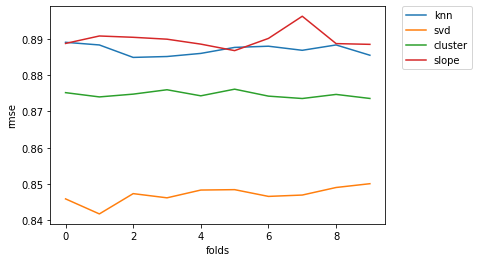

In [18]:
#Отобразим предсказания:
import matplotlib.pyplot as plt
modelPrediction = plt.plot(knn_recommender.rmse, label='knn')
modelPrediction = plt.plot(svd_recommender.rmse, label='svd')
modelPrediction = plt.plot(co_clusterning_recommender.rmse, label='cluster')
modelPrediction = plt.plot(slope_one_recommender.rmse, label='slope')

modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('rmse')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Похоже, что svd превосходит остальные. Попробуем гибридизировать модели, чтобы получить лучшие части каждой модели. Для этого мы собираемся использовать Suprise, чтобы создать новый алгоритм, и сделать так, чтобы он превосходил остальные.


# На псевдокоде наш алгоритм выглядит следующим образом:
1. Мы запускаем несколько рекомендательных систем для набора данных.
2. Инициализируем взвешенную переменную alpha равную 1 / q, где q - количество используемых нами рекомендательных систем.
3. Итоговый рейтинг будем считать как сумму взвещаных прогнозируемых рейтингов.
4. Используя градиентный спуск, оптимизируем альфа-член по пространству параметров, чтобы иметь возможность придать наибольший вес модели, которая может представлять лучший прогноз.

Теперь создадим класс в Surprise и унаследуем его от Algobase.

In [49]:
class HybridFacto(surprise.AlgoBase):
    
    def __init__(self, estimators=None, epochs=10, learning_rate=.05, q=4):
        if estimators is None:
            self.__stub_mode = True
            return
        self.alpha = np.array([1 / q] * q)
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.collabKNN = estimators[0]
        self.funkSVD = estimators[1]
        self.coClus = estimators[2]
        self.slopeOne = estimators[3]
        self.__stub_mode = False
    
    def fit(self, train_set):
        holdout=train_set.build_full_trainset().build_testset()
        predictions = []
        predictions.append(self.collabKNN.test(holdout))
        predictions.append(self.funkSVD.test(holdout))
        predictions.append(self.coClus.test(holdout))
        predictions.append(self.slopeOne.test(holdout))
        for epoch in range(self.epochs):
            maeGradient = np.array([surprise.accuracy.mae(prediction) for prediction in predictions])
            newalpha =  self.alpha - maeGradient * self.learning_rate
            #проверка сходимости:
            if (newalpha - self.alpha).max() < 0.001:
                break
            self.alpha = newalpha
            
    def estimate(self,testset):
        if self.__stub_mode:
            return [0.0]
        algoResults=[np.array([i.est for i in self.collabKNN.test(testset)]),
                     np.array([i.est for i in self.funkSVD.test(testset)]),
                     np.array([i.est for i in self.coClus.test(testset)]),
                     np.array([i.est for i in self.slopeOne.test(testset)])]
        return self.alpha @ algoResults
        
        
    def dump_instance(self, dump_path):
        with open(dump_path, 'wb') as dump_file:
            pickle.dump(self, dump_file, pickle.HIGHEST_PROTOCOL)
     
    
    @staticmethod
    def load_instance_from_dump(dump_path):
        with open(dump_path, 'rb') as dump_file:
            return pickle.load(dump_file)
        

давайте проверим его:
1. Инициализруйте Гибридную модель с 10 эпохами, learning_rate = 0.05, по 4 имеющимся моделям и обучите на holdout выборке
2. Посчитайте root mean squared error с использованием метрики из sklearn для получившегося результата
3. Отобразите на графике результаты метрики, полученые от одиночных моделей на предыдущих шагах вместе с результатом гибридной модели. Оцените результат

In [50]:
from sklearn.metrics import mean_squared_error
from math import sqrt

estimators = [knn_recommender.model,\
              svd_recommender.model,\
              co_clusterning_recommender.model,\
              slope_one_recommender.model]

hybrid = HybridFacto(estimators)
hybrid.fit(data)
kSplit = model_selection.split.KFold(n_splits=10, shuffle=True)

rmseHyb = []
for trainset, testset in kSplit.split(data):
    predhybrid = hybrid.estimate(testset)
    test_r = [i[2] for i in testset]
    fold_rmse = mean_squared_error(test_r, predhybrid)
    rmseHyb.append(fold_rmse)

MAE:  0.6032
MAE:  0.6275
MAE:  0.5886
MAE:  0.3314


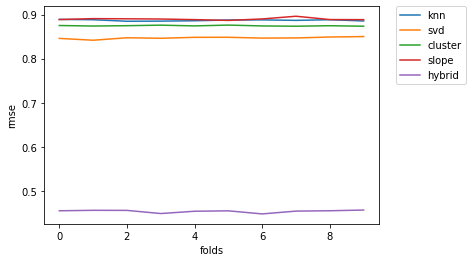

In [51]:
#plotting the prediction data:
modelPrediction = plt.plot(knn_recommender.rmse, label='knn')
modelPrediction = plt.plot(svd_recommender.rmse, label='svd')
modelPrediction = plt.plot(co_clusterning_recommender.rmse, label='cluster')
modelPrediction = plt.plot(slope_one_recommender.rmse, label='slope')
modelPrediction = plt.plot(rmseHyb, label='hybrid')

modelPrediction = plt.xlabel('folds')
modelPrediction = plt.ylabel('rmse')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Задание

Сохраните обученные модели для использования гибридного подхода и реализуйте возможность предсказания результата для id пользователя и фильма через веб-интерфейс с помощью REST-API фреймворка (flask/django)

In [52]:
hybrid.dump_instance('./recommender.pkl')

In [42]:
hybrid_loaded_from_dump = HybridFacto.load_instance_from_dump('./recommender.pkl')

In [62]:
to_predict = [(1, 100, 0)]
predicted = hybrid_loaded_from_dump.estimate(to_predict)
print(predicted)

[3.96746139]


In [48]:
hybrid_stub = HybridFacto()
to_predict = [(2799, 7033, 5.0)]
predicted = hybrid_stub.estimate(to_predict)
print(predicted)

[0.0]
